# Synthetic Turbulence Generation

Implementation of 
"Synthetic Turbulence Generators for RANS-LES Interfaces in Zonal Simulations of Aerodynamic and Aeroacoustic Problems" by Spallart et al.
https://link.springer.com/content/pdf/10.1007/s10494-014-9534-8.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy.interpolate import interp1d

%matplotlib notebook
# %matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
nstart = 0
ny = 340

prof = pd.read_csv('turbulence_statistics/Re_theta.1551.prof', skiprows=31, header=0, sep=' ', skipinitialspace=True)[nstart:ny]
bal_uu = pd.read_csv('turbulence_statistics/Re_theta.1551.bal.uu', skiprows=31, header=0, sep=' ', skipinitialspace=True)[nstart:ny]
bal_vv = pd.read_csv('turbulence_statistics/Re_theta.1551.bal.vv', skiprows=31, header=0, sep=' ', skipinitialspace=True)[nstart:ny]
bal_ww = pd.read_csv('turbulence_statistics/Re_theta.1551.bal.ww', skiprows=31, header=0, sep=' ', skipinitialspace=True)[nstart:ny]
bal_uv = pd.read_csv('turbulence_statistics/Re_theta.1551.bal.uv', skiprows=31, header=0, sep=' ', skipinitialspace=True)[nstart:ny]


In [3]:
print(prof.keys())
print(bal_uu.keys())

Index(['y/d99', 'y+', 'urms', 'vrms', 'wrms', 'uv', 'umed', 'vmed', 'wmed',
       'u3', 'v3', 'u2v', 'v2u', 'w2u', 'w2v', 'dumdy', 'dvmdy', 'dwmdy',
       'ozmed', 'oxrms', 'oyrms', 'ozrms', 'pm', 'pp', 'Unnamed: 24'],
      dtype='object')
Index(['y/d99', 'y+', 'Produc.', 'Advect.', 'Turflux', 'Presflux', 'Dissip.',
       'Viscous', 'Unnamed: 8'],
      dtype='object')


In [4]:
# ny = 360,          Re_{theta} = 1551.0276, Re_{tau} = 577.7820,
# delta_99 = 3.7687, theta = 0.4433,          u_{tau} = 0.0438,

# Parameters
Re_tau = 577.7820
u_tau = 0.0438
# delta_99 = 3.7687
delta_99 = 0.548
Uinf = 1.0
nu = u_tau * delta_99 / Re_tau
print("1 / nu = ",1 / nu)

y = (prof['y/d99'] * delta_99).values
u_mean = prof['umed'].values * u_tau
v_mean = prof['vmed'].values * u_tau

1 / nu =  24071.842815718428


In [5]:
u_tau / nu

1054.346715328467

## Compute Epsilon

In [9]:
# epsilon = (bal_uu['Dissip.'].values + bal_vv['Dissip.'].values + bal_ww['Dissip.'].values) * u_tau ** 4 / nu
epsilon = (bal_uu['Dissip.'].values + bal_vv['Dissip.'].values + bal_ww['Dissip.'].values) * u_tau ** 2
# epsilon = (bal_uu['Dissip.'].values + bal_vv['Dissip.'].values + bal_ww['Dissip.'].values) * (nu / delta_99**2)
tke = 0.5 * (prof['urms'] + prof['vrms'] + prof['wrms']).values * u_tau ** 2
l_eta = (nu**3 / np.abs(epsilon)) ** 0.25 # Kolmogorov lenght scale
k_eta = 2 * np.pi / l_eta

C_mu = 0.09
l_t = - C_mu * tke ** (3/2) / epsilon

C_l = 3.0
l_e = np.minimum(2 * y, C_l * l_t)
k_e = 2 * np.pi / l_e

l_e_max = np.max(l_e)
k_e_min = np.min(k_e)
beta = 0.5
k_min = beta * k_e_min

N = 285
alpha = 0.02
k_n = k_min * (1 + alpha) ** np.arange(N)

# These are the local grid steps
betam = 3.7
yi_ = np.linspace(0,1,16 * 7+1)
y_ = 5 * (np.tanh(betam * (yi_ - 1.)) / np.tanh(betam) + 1.)
dy_ = (y_[1:] - y_[:-1])
dy = interp1d(y_[:-1], dy_)
h_x = 0.01785
h_y = 0.01 # This is a function of y - keep it fixed for now but I have to use the right one in Nek!!!
# h_y = dy(y)
h_z = 0.01785
# h_max = np.max([h_x, h_y, h_z])
h_max = np.maximum(h_x, h_y)

l_cut = 2 * np.minimum(np.maximum(np.maximum(h_y, h_z), 0.3 * h_max) + 0.1 * y, h_max)
k_cut = 2 * np.pi / l_cut

print(f'Check if kN = {k_n[-1]} is >= k_max = 1.5 k_cut = {1.5 * np.max(k_cut)}')

Check if kN = 267.59905508039367 is >= k_max = 1.5 k_cut = 263.99938265460446


/tmp/ipykernel_305629/116606662.py:13: RuntimeWarning: divide by zero encountered in divide
  k_e = 2 * np.pi / l_e


In [10]:
E_n = (
        (k_n.reshape(-1,1) / k_e.reshape(1,-1))**4 / (1 + 2.4 * (k_n.reshape(-1,1) / k_e.reshape(1,-1))**2)**(17/6) 
        * np.exp(-(12 * k_n.reshape(-1,1) / k_eta.reshape(1,-1))**2) 
        * np.exp(-(4 * np.max(k_n.reshape(-1,1) - 0.9 * k_cut.reshape(1,-1), 0) / k_cut.reshape(1,-1))**3)
    )

<IPython.core.display.Javascript object>


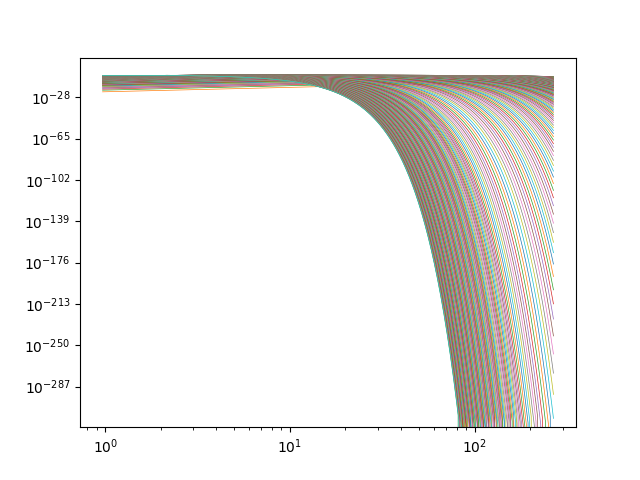

In [11]:
fig, ax = plt.subplots()
ax.plot(k_n, E_n, lw=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

In [12]:
# Normalized amplitudes of modes

delta_k_n_tmp = k_min * alpha * (1 + alpha) ** np.arange(1,N)
delta_k_n = np.hstack((delta_k_n_tmp[0], (delta_k_n_tmp[:-1] + delta_k_n_tmp[1:]), delta_k_n_tmp[-1])) / 2.

q_denom = np.sum(E_n * delta_k_n.reshape(-1,1), axis=0)

q_n = E_n * delta_k_n.reshape(-1,1) / q_denom

/tmp/ipykernel_305629/4150953362.py:8: RuntimeWarning: invalid value encountered in divide
  q_n = E_n * delta_k_n.reshape(-1,1) / q_denom


In [13]:
# Random unit vectors (defined once)

phi = 2 * np.pi * np.random.rand(N)
phi_1 = 2 * np.pi * np.random.rand(N)
phi_2 = 2 * np.pi * np.random.rand(N)
phi_3 = 2 * np.pi * np.random.rand(N)

d_n = np.vstack((np.sin(phi_1) * np.cos(phi_2), np.sin(phi_1) * np.sin(phi_2), np.cos(phi_1)))

phi_4 = np.arctan2(-d_n[2], d_n[0] * np.cos(phi_3) + d_n[1] * np.sin(phi_3))

sigma_n = np.vstack((np.sin(phi_4) * np.cos(phi_3), np.sin(phi_4) * np.sin(phi_3), np.cos(phi_4)))

## Generate Random Velocity Field

In [14]:
U0 = 1.0

t = 1.1
j = 100 # y index
rx = - 2 * np.pi / k_n / l_e_max * U0 * t
ry = y[j] * np.ones_like(k_n)
rz = 1.25 * np.ones_like(k_n)

# r = np.array([rx, ry, rz])
r = np.vstack((rx, ry, rz))

v_prime = np.sqrt(6) * np.sum(np.sqrt(q_n[:,j]) * sigma_n * np.cos(k_n * np.sum(d_n * r, axis=0) + phi), axis=-1)

<IPython.core.display.Javascript object>


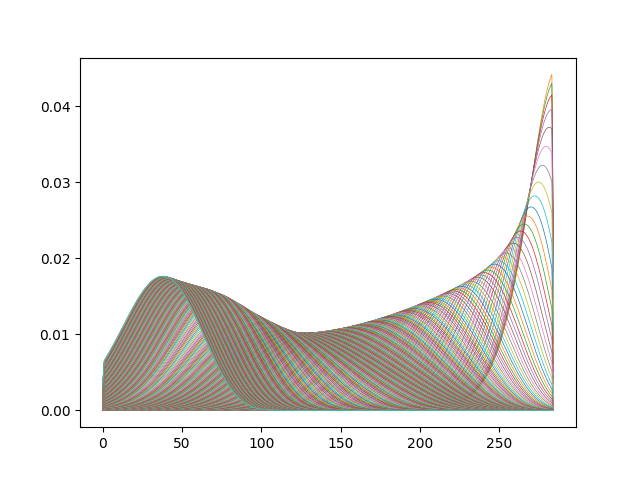

In [15]:
fig, ax = plt.subplots()
ax.plot(q_n, lw=0.5)
# ax.set_xscale('log')
# ax.set_yscale('log')

In [16]:
u_rms = interp1d(y, prof['urms'].values * u_tau**2)
v_rms = interp1d(y, prof['vrms'].values * u_tau**2)
w_rms = interp1d(y, prof['wrms'].values * u_tau**2)
uv = interp1d(y, prof['uv'].values * u_tau**2)

def reynolds_stress_tensor(yi):
    R11 = u_rms(yi)
    R22 = v_rms(yi)
    R33 = w_rms(yi)
    R21 = uv(yi)
    
    A = np.zeros((3,3))
    A[0,0] = np.sqrt(R11)
    A[1,0] = R21 / A[0,0]
    A[1,1] = np.sqrt(R22 - A[1,0]**2)
    A[2,2] = np.sqrt(R33)
    
    return A

In [19]:
U0 = 5.0

num_y = len(y)
num_z = 301
# Y = np.repeat(np.linspace(0.1,6,num_y), num_z).reshape(-1, num_z)
Y = np.repeat(y, num_z).reshape(-1, num_z)
Z = np.tile(np.linspace(0,2.5,num_z), num_y).reshape(num_y, -1)
u = np.zeros((num_y, num_z, 3))

t = 1.2
rx = - 2 * np.pi / k_n / l_e_max * U0 * t

for i in range(num_y):
    A = reynolds_stress_tensor(Y[i,0])
    for j in range(num_z):
        ry = Y[i,j] * np.ones_like(k_n)
        rz = Z[i,j] * np.ones_like(k_n)
        r = np.vstack((rx, ry, rz))
        u[i,j] = np.sqrt(6) * np.sum(np.sqrt(q_n[:,i]) * sigma_n * np.cos(k_n * np.sum(d_n * r, axis=0) + phi), axis=-1)
        u[i,j] = A @ u[i,j]


/tmp/ipykernel_305629/1010640235.py:14: RuntimeWarning: invalid value encountered in divide
  A[1,0] = R21 / A[0,0]


<IPython.core.display.Javascript object>


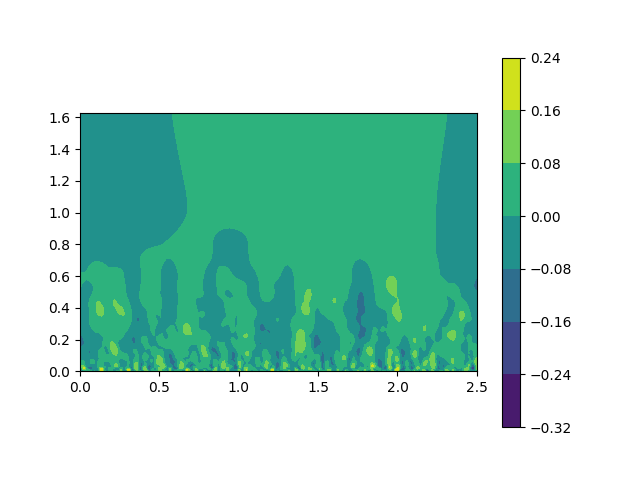

In [20]:
fig, ax = plt.subplots()
cont = ax.contourf(Z.T, Y.T, u[:,:,0].T)
cbar = plt.colorbar(cont)
ax.set_aspect('equal', 'box')

In [30]:
U0 = 4.0

num_t = 1000
t = 0.0025 * np.arange(num_t)
yc = y[100]
zc = 1.25
ut = np.zeros((num_t, 3))
A = reynolds_stress_tensor(yc)

ry = yc * np.ones_like(k_n)
rz = zc * np.ones_like(k_n)
for i in range(num_t):
    rx = - 2 * np.pi / k_n / l_e_max * U0 * t[i]
    r = np.vstack((rx, ry, rz))
    ut[i] = np.sqrt(6) * np.sum(np.sqrt(q_n[:,100]) * sigma_n * np.cos(k_n * np.sum(d_n * r, axis=0) + phi), axis=-1)
    ut[i] = A @ ut[i]

<IPython.core.display.Javascript object>


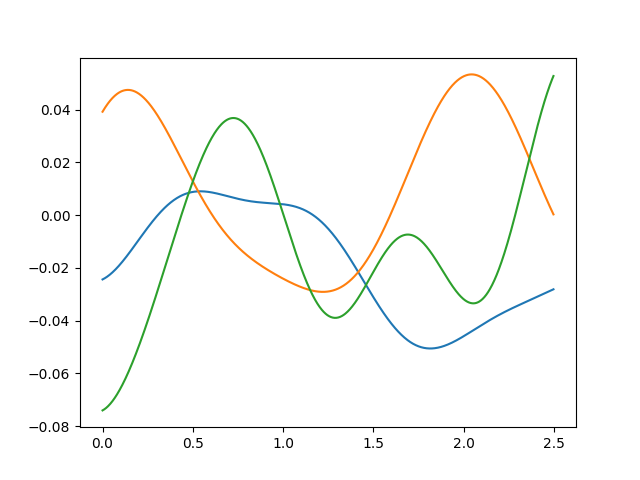

In [31]:
fig, ax = plt.subplots()
cont = ax.plot(t, ut)

## Save profiles for Nek5000

In [32]:
q_n = np.nan_to_num(q_n, nan=0.0)

In [33]:
with open('turbulent_inflow.prof', 'w') as f:
    f.write(str(ny) + "\n")
    f.write("# y    u_mean    v_mean    u_rms    v_rms    w_rms    uv\n")
    np.savetxt(f, np.vstack((
        y, 
        u_mean,
        v_mean,
        prof['urms'].values * u_tau**2,
        prof['vrms'].values * u_tau**2,
        prof['wrms'].values * u_tau**2,
        prof['uv'].values * u_tau**2,
    )).T)

with open('turbulent_inflow.freq', 'w') as f:
    f.write(str(N) + "\n")
    f.write(str(len(y)) + "\n")
    f.write(str(l_e_max) + "\n")
    f.write("# q_n    sigma_n    k_n    d_n    phi_n    uv\n")
    np.savetxt(f, np.hstack((
        q_n,
        sigma_n.T,
        k_n[:,np.newaxis],
        d_n.T,
        phi[:,np.newaxis]
    )))